In [1]:
import os.path as osp
from helper import find_best_model_in_metric_file  
import matplotlib.pylab as plt
from collections import  defaultdict
from general_tools.simpletons import sort_dict_by_key
from operator import itemgetter

In [2]:
%matplotlib inline

In [3]:
top_sample_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/'
top_evaluation_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/synthetic_data/'

In [4]:
def stored_synthetic_samples(class_name):
    sample_dir = {'l_gan_emd': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128'),
                  'l_gan_chamfer': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128'),
                  'l_w_gan_small': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch'),
                  'l_w_gan_large': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch_double_neurons'),
                  'r_gan': osp.join(top_sample_dir, 'r_gan/r_gan_' + class_name + '_mlp_disc_4_fc_gen_raw_gan_2048_pts'),
                  'gmm': osp.join(top_sample_dir, 'gmm/gmm_emd_' + class_name)
                 }
    
    return sample_dir

In [23]:
def read_evaluation_file(in_file):
    all_lines = []
    res = dict()
    with open(in_file, 'r') as fin:
        for line in fin:
            l = line.rstrip()
            if len(l) > 0:
                all_lines.append(l)
    return all_lines

def tokenize_evaluation_data(in_lines):
    current_model = None
    data_dict = defaultdict(dict)
    
    def model_name(model):
        if model.startswith('epoch'):
            return int(model[len('epoch_'):])

        elif model.endswith('gaussians'):
            tok = model.split('_')
            cov_type = tok[-3]
            n_gaussians = tok[-2]
            return cov_type + '_' + n_gaussians
            
    for line in in_lines:
        token = line.split()
        if token[0] not in ['train', 'test', 'val']:
            current_model = model_name(token[0])        # Varying epoch or n_gaussians 
        else:
            try:
                split, metric_value, metric_std = token # has - mean and std
            except:
                split, metric_value = token
                metric_std = 0
                
            metric_value = float(metric_value)
            metric_std = float(metric_std)
            data_dict[split][current_model] = (metric_value, metric_std)            
    return data_dict
    
    
def find_best_model_in_metric(in_file, sort_by='test', report=['train', 'test', 'val']):    
    all_lines = read_evaluation_file(in_file)
    data_dict = tokenize_evaluation_data(all_lines)
    stats = data_dict[sort_by]
    best_model = sorted([(stats[s][0], stats[s][1], s) for s in stats.keys()])[0]
    res = dict()
    for s in report:
        if s in data_dict:
            res[s] = (best_model[2], data_dict[s][best_model[2]])        
    return res

def collect_data_for_all_experiments(exp_dict, metric):
    data_col = dict()
    for key in exp_dict.keys(): 
        exp_name = osp.basename(exp_dict[key]) 
        in_file = osp.join(top_evaluation_dir, class_name, metric, exp_name + '.txt')
        
        all_lines = read_evaluation_file(in_file)
        data_col[key] = tokenize_evaluation_data(all_lines)
    return data_col

def stats_per_epoch_or_gaussian_type(data_dict, split='train'):
    d = data_dict[split]
    x = []
    y = []
    e = []
    for key, val in sort_dict_by_key(d):
        x.append(key)
        y.append(val[0])
        e.append(val[1])
    return x, y, e

In [6]:
class_name = 'chair'
exp_dict = stored_synthetic_samples(class_name)

In [7]:
boost_5_data = collect_data_for_all_experiments(exp_dict, 'mmd_chamfer_all_gt_boost_sample_5')
emd_40_200_data = collect_data_for_all_experiments(exp_dict, 'mmd_emd_10_samples_40gt_200_synthetic')
jsd_data = collect_data_for_all_experiments(exp_dict, 'jsd')

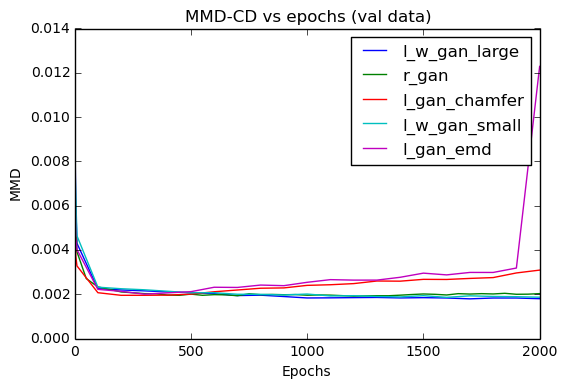

In [74]:
legend_names = []
split = 'val'
for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(boost_5_data[key], split)
        plt.plot(x1, y1)        
        legend_names.append(key)
# plt.xticks(range(len(x1)), x1, rotation='vertical')    
plt.legend(legend_names)
plt.title('MMD-CD vs epochs (%s data)'%(split))
plt.ylabel('MMD')
plt.xlabel('Epochs')

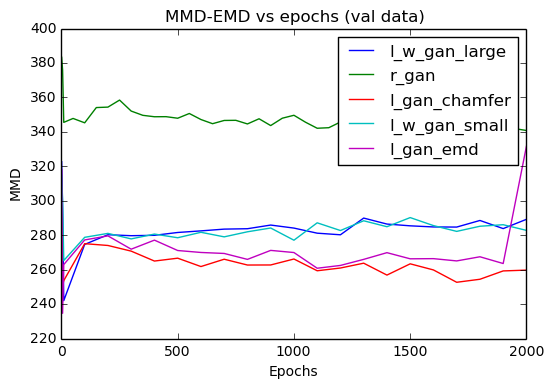

In [70]:
legend_names = []
split = 'val'
for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(emd_40_200_data[key], split)
        plt.plot(x1, y1)        
        legend_names.append(key)
# plt.xticks(range(len(x1)), x1, rotation='vertical')    
plt.legend(legend_names)
plt.title('MMD-EMD vs epochs (%s data)'%(split))
plt.ylabel('MMD')
plt.xlabel('Epochs')

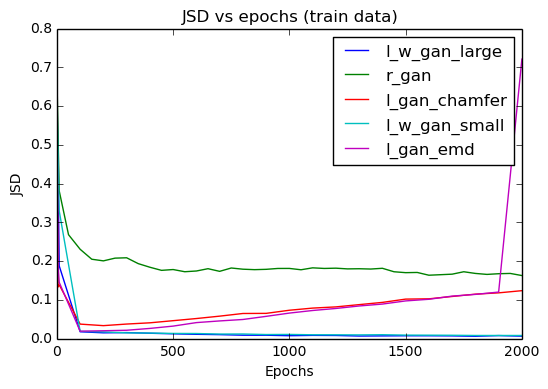

In [73]:
legend_names = []
split = 'train'
for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], split)
        plt.plot(x1, y1)
        legend_names.append(key)
plt.legend(legend_names)
plt.title('JSD vs epochs (%s data)'%(split))
plt.ylabel('JSD')
plt.xlabel('Epochs')

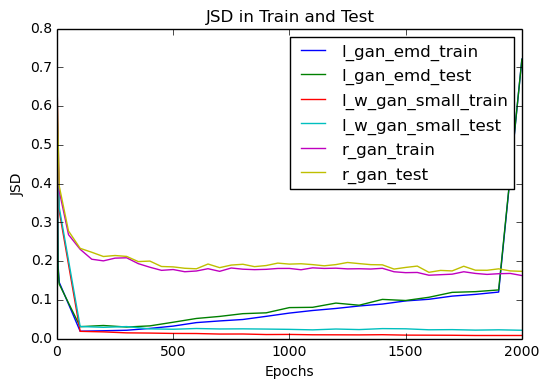

In [9]:
legend_names = []
split = 'train'
for key in ['l_gan_emd', 'l_w_gan_small', 'r_gan']:
    x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'train')
    plt.plot(x1, y1)
    legend_names.append(key + '_train')
    x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'val')
    plt.plot(x1, y1)
    legend_names.append(key + '_test')
    
plt.legend(legend_names)
plt.title('JSD in Train and Test')
plt.ylabel('JSD')
plt.xlabel('Epochs')

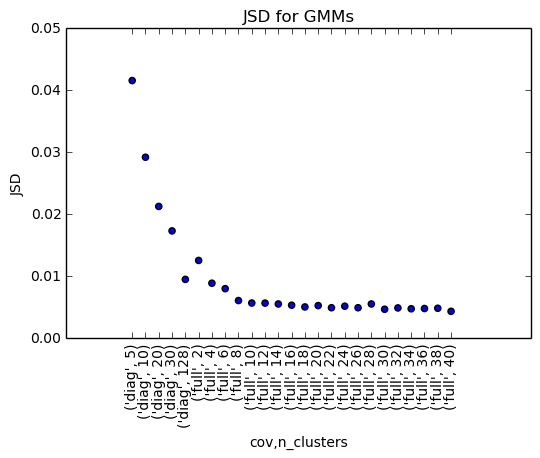

In [54]:
legend_names = []
split = 'train'
for key in ['gmm']:
    labels, y, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'train')    
    labels_ = [l.split('_')for l in labels]
    labels_ = [(l[0], int(l[1])) for l in labels_]
    arg_labels = sorted(enumerate(labels_), key=itemgetter(1))
    labels = [l[1] for l in arg_labels]
    arg_y = [l[0] for l in arg_labels]
    x = np.arange(len(labels))
    plt.scatter(x, np.array(y)[arg_y])
    plt.xticks(x, labels, rotation='vertical')    
    plt.title('JSD for GMMs')
    plt.ylabel('JSD')
    plt.xlabel('cov,n_clusters')

In [ ]:
metric_to_plot = 'jsd'

for key in exp_dict.keys():
    print key
    exp_name = osp.basename(exp_dict[key]) 
    in_file = osp.join(top_evaluation_dir, class_name, metric_to_plot, exp_name + '.txt')
    all_lines = read_evaluation_file(in_file)
    in_data = tokenize_evaluation_data(all_lines, sort_by_metric)

#         if 'gan' in exp_name:
#             legend_names.append(key)
#             x, y, e = stats_per_epoch_or_n_clusters(data_dict, split='test')
#             plt.plot(x, y)
#             plt.errorbar(x, y, yerr=e, fmt='-o')    
#     except:
#         pass
#     plt.legend(legend_names)
#     plt.title('MMD via EMD:10-40-200 on Test')
#     plt.title('MMD via CD :5x_boost, Test')

In [29]:
sort_by_metric = 'mmd_chamfer_all_gt_boost_sample_5'
metric_eval_at = ['test', 'val']
legend_names = []

for key in exp_dict.keys():
    print 
    print key
    exp_name = osp.basename(exp_dict[key]) 
    in_file = osp.join(top_evaluation_dir, class_name, sort_by_metric, exp_name + '.txt')
    best_model = find_best_model_in_metric(in_file, sort_by_metric, sort_by='test')
    best_id = best_model['test'][0]    
    print 'best epoch', best_id    
#     for split in metric_eval_at:
#         print sort_by_metric, split, '%.4f'%(best_model[split][1][0], )
        
# #         if split in boost_5[key]:
# #             st = boost_5[key][split][best_id]
# #             print 'cd_boost_5 %.4f %.4f' % (st[0], st[1])
        
#         if split in emd_40_200[key]:
#             st = emd_40_200[key][split][best_id]
#             print 'emd_40_200 %.3f %.3f' %(st[0] / float(2048), st[1] / float(2048))
        
#         if split in jsd_data[key]:
#             st = jsd_data[key][split][best_id]
#             print 'jsd %.4f' %(st[0])


l_w_gan_large
best epoch 2000

gmm
best epoch full_40

r_gan
best epoch 1350

l_gan_chamfer
best epoch 300

l_w_gan_small
best epoch 1700

l_gan_emd
best epoch 200
